# Requirements

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pyproj
import random
import shapely.ops as ops
import statistics
import warnings

from functools import partial
from matplotlib import cm
from osmnx import geometries as ox_geometries
from scipy.sparse import linalg

# Constants

In [146]:
# -- Location --
# LOCATION = "York, Yorkshire and the Humber, England, YO1 8SG, United Kingdom"
LOCATION = (53.9586012, -1.0807963) # Co-ordinates for in town
DIST = 2000 # Radius to consider

# -- Road Network --
HOME_TYPES = {'building': ["house", "terrace", "residential", "detached", "garage", "semidetached_house", "apartments"]} # Attributes that signify a place of residence
BUILDING_TYPES = {'building': ['library', 'retail', 'supermarket', 'shop', 'gatehouse', # Attributes that signify a business, workplace, or public ammenity
       'cathedral', 'church', 'castle', 'university', 'pavilion',
       'kindergarten', 'public', 'hotel', 'palace', 'sports_centre',
       'cinema', 'office', 'industrial', 'warehouse', 'school', 'chapel',
       'museum', 'toilets', 'train_station', 'college', 'hospital',
       'manufacture', 'commercial', 'tower', 'service', 'historic',
       'hall', 'greenhouse', 'civic', 'pub', 'ambulance_station',
       'Dentist', 'stadium', 'community', 'kiosk', 'bridge', 'boathouse']}

# -- Eigendata Centrality --
SMOOTHING_FACTOR = 0

# -- Road pedestrianisation --
HIGHWAY_TYPES_TO_ALWAYS_KEEP = ['service'] # Highways that are never to be removed even if they have a high eigendata value (e.g. car parks, access roads)
PROPORTION_TO_PEDESTRIANISE = 0.02

# -- Traffic Simulation --
NON_CAR_HIGHWAYS = ['footway', 'cycleway', 'path', 'steps', 'bridleway'] # Highways that a car could never have used (pedestrianised roads are still being considered)
NUMBER_OF_JOURNEYS = 1000
ASSUMED_MAX_SPEED = 30 #Mph

# -- Graph Plotting --
FIG_SIZE = (15,15)
NODE_SIZE = 0
BG_COLOUR = 'black'
HIGHWAY_COLOUR = 'grey'
HOME_COLOUR = 'blue'
BUILDING_COLOUR = 'orange'
NUMBER_OF_BINS = 100

# Preperation

## Download map data

In [3]:
clean_highway_graph = ox.graph_from_point(LOCATION, network_type='all', dist=DIST)
clean_home_set = ox_geometries.geometries_from_point(LOCATION, HOME_TYPES, dist=DIST)
clean_building_set = ox_geometries.geometries_from_point(LOCATION, BUILDING_TYPES, dist=DIST)

if type(LOCATION) == tuple:
    clean_highway_graph = ox.graph_from_point(LOCATION, network_type='all', dist=DIST)
    clean_home_set = ox_geometries.geometries_from_point(LOCATION, HOME_TYPES, dist=DIST)
    clean_building_set = ox_geometries.geometries_from_point(LOCATION, BUILDING_TYPES, dist=DIST)
else:
    clean_highway_graph = ox.graph_from_place(LOCATION, network_type='all')
    clean_home_set = ox_geometries.geometries_from_place(LOCATION, HOME_TYPES)
    clean_building_set = ox_geometries.geometries_from_place(LOCATION, BUILDING_TYPES)

In [4]:
#TODO: Remove this for final use, just name the downloaded ones normally
highway_graph = clean_highway_graph.copy()
home_set = clean_home_set.copy()
building_set = clean_building_set.copy()

## Clean up map and re-index nodes

In [5]:
# Remove isolated nodes 
highway_graph.remove_nodes_from(list(nx.isolates(highway_graph)))

# re-index the nodes
highway_graph = nx.convert_node_labels_to_integers(highway_graph, first_label=0, ordering='default')

# Plot map of area

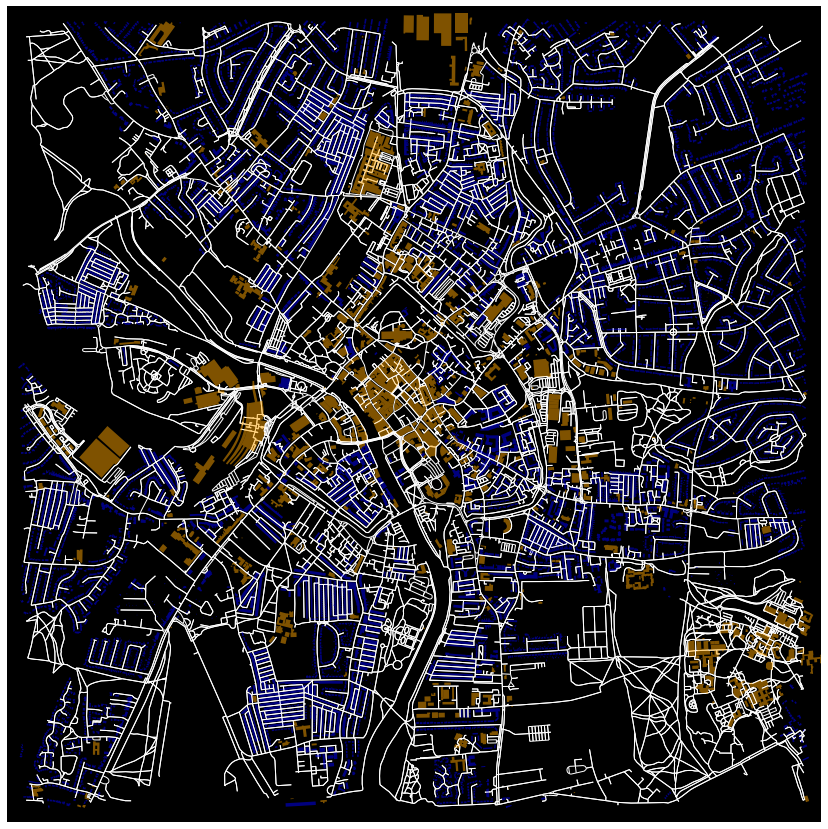

In [6]:
ax = None
fig, ax = ox.plot_graph(highway_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color=HIGHWAY_COLOUR, figsize=FIG_SIZE)
home_set.plot(ax=ax, facecolor=HOME_COLOUR, alpha=0.5)
building_set.plot(ax=ax, facecolor=BUILDING_COLOUR, alpha=0.5)
# plt.title("Graph of York", size=30)
# plt.suptitle("Blue: residential\nRed: commerical / workplaces", size=20, horizontalalignment='left', verticalalignment='bottom', x=0.135, y=0.09)
plt.show()

# Calculate Building Eigendata Centrality

In [7]:
def normalise(vector):
    norm = []
    maxVal = max(vector)
    for i in range(len(vector)):
        norm.append(vector[i] / maxVal)
    return norm

def calculate_polygon_area(polygon):
    warnings.filterwarnings('ignore')
    epsg = pyproj.Proj('EPSG:4326')
    aea = pyproj.Proj(proj='aea',
                    lat_1=polygon.bounds[1],
                    lat_2=polygon.bounds[3])
    transformer = partial(pyproj.transform, epsg, aea)
    polygon_area = ops.transform(transformer, polygon)
    warnings.filterwarnings('default')
    return polygon_area.area

def create_data_map(graph, geometry_set, default_val=None):
    coords = []
    areas = {}

    for i in range(len(geometry_set)):
        shape = geometry_set.geometry[i]
        if shape.geom_type == "Polygon" or shape.geom_type == "MultiPolygon":
            point = shape.centroid
            area = calculate_polygon_area(shape)
        else:
            point = shape
            area = avg_area
        coords.append((point.y, point.x))
        areas[(point.y, point.x)] = area

    avg_area = statistics.median(areas.values())

    dataMap = {}
    for point in coords:
        nearestNode = ox.distance.nearest_nodes(graph, point[1], point[0])
        dataMap[nearestNode] = dataMap.get(nearestNode, 0) + (areas[point])

    if default_val == None:
        default_val = min(areas.values())/10

    for node in graph.nodes(data=False):
        if node not in dataMap.keys():
            dataMap[node] = default_val
    
    return dataMap

In [8]:
# Create Data Map - dictionary mapping each node to its weight
dataMap = create_data_map(highway_graph, building_set, default_val=0)

# Create Data Vector - list of every nodes's weight
dataVector = []
for node in highway_graph.nodes():
    if node in dataMap.keys():
        dataVector.append(dataMap[node])
    else:
        dataVector.append(0)
# Generate adjacency matrix
adjacencyMatrix = nx.adjacency_matrix(highway_graph)

# Normalise the data vector
normalisedVector = normalise(dataVector)

# Create a weight matrix for connecting each node to other nodes
size = len(highway_graph.nodes())
weightMatrix = np.empty([size, size])

for node0, node1 in highway_graph.edges():
    weightMatrix[node0][node1] = normalisedVector[node0] + normalisedVector[node1]

# Compute base importance
baseImportance = np.min(weightMatrix[np.nonzero(weightMatrix)])

if SMOOTHING_FACTOR != 0:
    smooth_factor = baseImportance / SMOOTHING_FACTOR
else:
    smooth_factor = 0

# Construct weighted adjacency matrix for connecting nodes
ones = np.ones(np.shape(weightMatrix))
weightedAdjacencyMatrix = np.multiply(adjacencyMatrix.A, ((weightMatrix + (baseImportance*ones)))) + (smooth_factor*ones)

# Find dominant eigenpair
eigenValues, eigenVectors = linalg.eigs(weightedAdjacencyMatrix, k=1, which='LM')
dominantEigenValue = eigenValues.flatten().real
dominantEigenVector = eigenVectors.flatten().real

# Compute eigendata centralities
eig = (1/dominantEigenValue) * (np.matmul(adjacencyMatrix.A, dominantEigenVector) + dominantEigenVector)

# Find the absolute value for all eigendata values
eigendataCentrality = []
for elm in eig:
    if elm < 0 :
        elm = elm * -1
    eigendataCentrality.append(elm)

# Add eigendata centrality to nodes
eigDict = {}
for i in range(len(highway_graph.nodes(data=False))):
    eigDict[i] = eigendataCentrality[i]
    
nx.set_node_attributes(highway_graph, eigDict, name='eigendata')

# Add an eigendata value to each road that takes the average of its nodes
eigDict = {}
edges = list(highway_graph.edges(data=False, keys=True))
for i in range(len(edges)):
    edge = edges[i]
    nodeA = highway_graph.nodes.get(edge[0])
    nodeB = highway_graph.nodes.get(edge[1])
    eigDict[edge] = (nodeA['eigendata'] + nodeB['eigendata']) / 2
    
nx.set_edge_attributes(highway_graph, eigDict, name='eigendata')

## Plot Eigendata

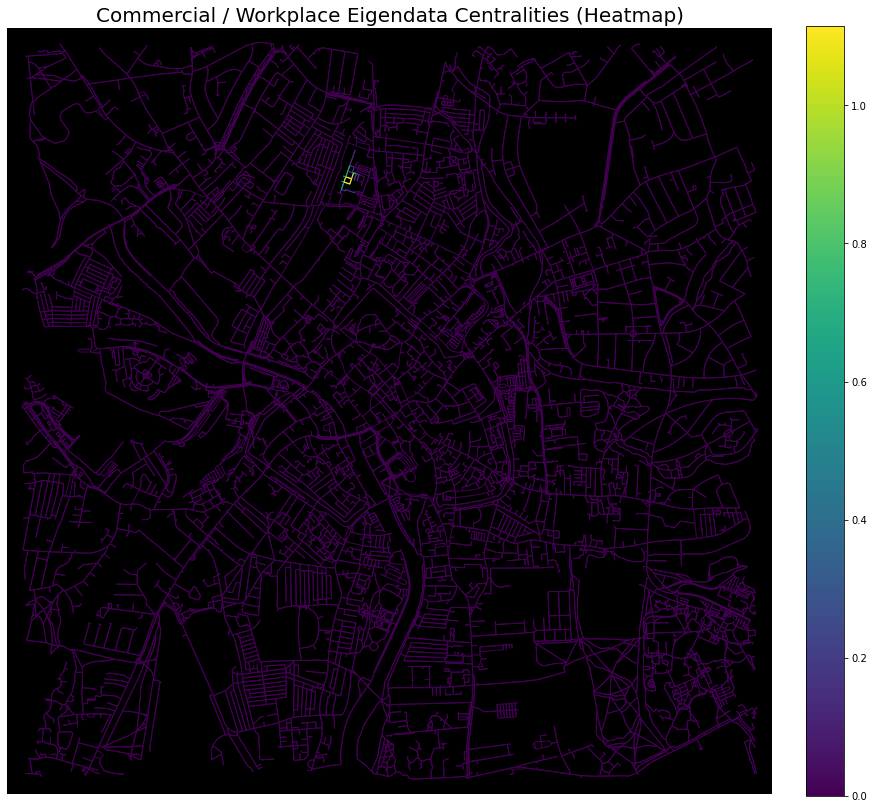

In [9]:
highway_eigs = dict(highway_graph.nodes(data='eigendata')).values()

# Create Colours
norm=plt.Normalize(vmin=min(highway_eigs), vmax=max(highway_eigs))
cmap=plt.cm.viridis
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(eigendataCentrality)

# Map colours to values (Linear / Heatmap)
edgeColours = ox.plot.get_edge_colors_by_attr(highway_graph, attr='eigendata', cmap=cmap)
nodeColours = ox.plot.get_node_colors_by_attr(highway_graph, attr='eigendata', cmap=cmap)

ax = None
fig, ax = ox.plot_graph(highway_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color=edgeColours, node_color=nodeColours, figsize=FIG_SIZE)

# Plot scale & Title
cb = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
plt.title('Commercial / Workplace Eigendata Centralities (Linear)', fontsize=20)
plt.show()

[]

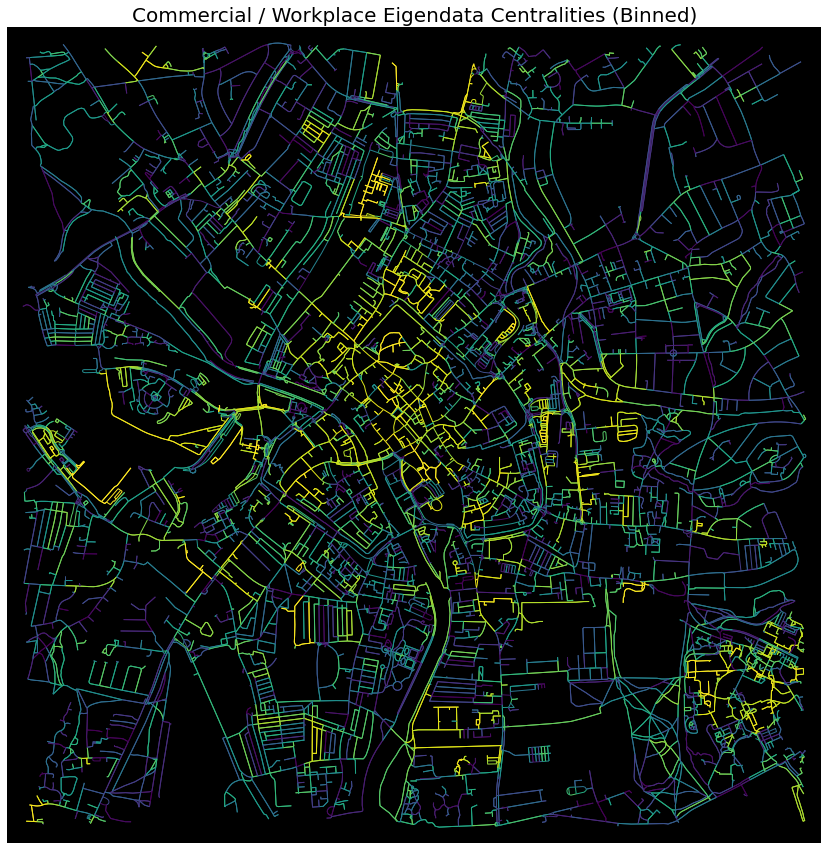

In [10]:
highway_eigs = dict(highway_graph.nodes(data='eigendata')).values()

# Create Colours
norm=plt.Normalize(vmin=min(highway_eigs), vmax=max(highway_eigs))
cmap=plt.cm.viridis

# Map colours to values (Binning)
edgeColours = ox.plot.get_edge_colors_by_attr(highway_graph, attr='eigendata', num_bins=NUMBER_OF_BINS, equal_size=True, cmap=cmap)
nodeColours = ox.plot.get_node_colors_by_attr(highway_graph, attr='eigendata', num_bins=NUMBER_OF_BINS, equal_size=True, cmap=cmap)

ax = None
fig, ax = ox.plot_graph(highway_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color=edgeColours, node_color=nodeColours, figsize=FIG_SIZE)
# home_set.plot(ax=ax, facecolor=HOME_COLOUR, alpha=0.1)
# building_set.plot(ax=ax, facecolor=BUILDING_COLOUR, alpha=0.1)
plt.title('Commercial / Workplace Eigendata Centralities (Binned)', fontsize=20)

plt.plot()

# Initial Journey Time Calculations

## Create a graph of roads

In [11]:
# Copy graph
road_graph = highway_graph.copy()

# Create list of highways to remove
toRemove = []
for edge in road_graph.edges(data=True):
    tags = edge[2]['highway']
    if type(tags) != list:
        tags = [tags]
    for tag in tags:
        if tag in NON_CAR_HIGHWAYS and edge not in toRemove:
            toRemove.append(edge)

# Remove these highways from the graph of roads
for edge in toRemove:
    road_graph.remove_edge(edge[0], edge[1])

# Remove isolated nodes
road_graph.remove_nodes_from(list(nx.isolates(road_graph)))

# Ensure graph is connected by selecting largest connected component 
road_graph = ox.utils_graph.get_largest_component(road_graph, strongly=False)

# Re-index the remaining nodes
road_graph = nx.convert_node_labels_to_integers(road_graph, first_label=0, ordering='default')

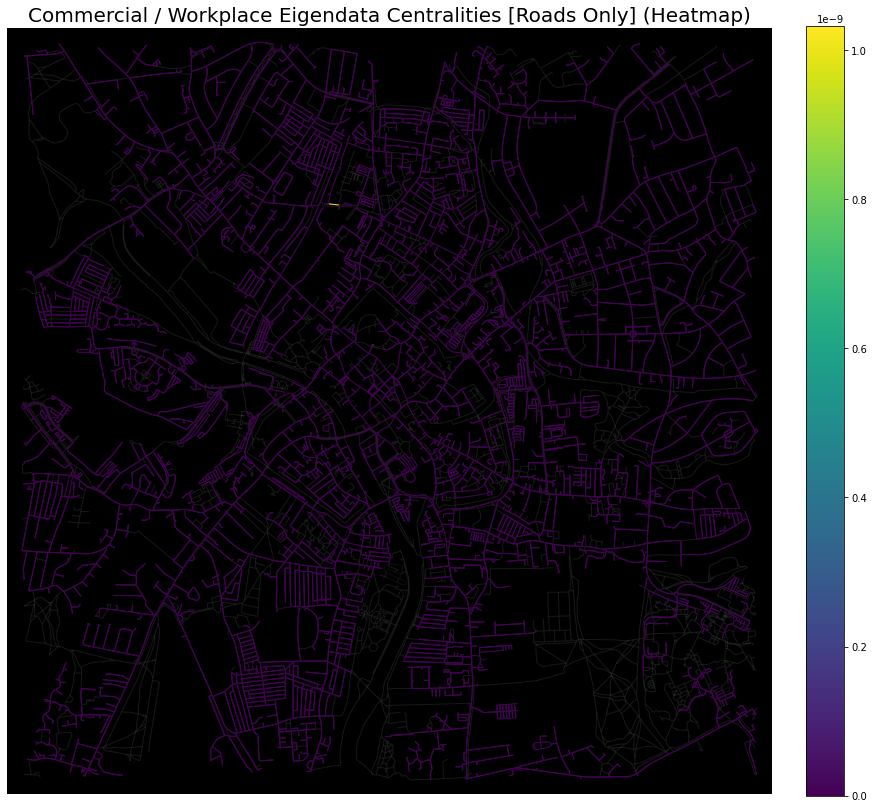

In [12]:
road_eigs = dict(road_graph.nodes(data='eigendata')).values()

# Create Colours
norm=plt.Normalize(vmin=min(road_eigs), vmax=max(road_eigs))
cmap=plt.cm.viridis
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(eigendataCentrality)

# Map colours to values (Linear / Heatmap)
edgeColours = ox.plot.get_edge_colors_by_attr(road_graph, attr='eigendata', cmap=cmap)
nodeColours = ox.plot.get_node_colors_by_attr(road_graph, attr='eigendata', cmap=cmap)

ax = None
fig, ax = ox.plot_graph(highway_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color='grey', node_color=nodeColours, figsize=FIG_SIZE, edge_alpha=0.1)
fig, ax = ox.plot_graph(road_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color=edgeColours, node_color=nodeColours, figsize=FIG_SIZE)
# home_set.plot(ax=ax, facecolor=HOME_COLOUR, alpha=0.1)
# building_set.plot(ax=ax, facecolor=BUILDING_COLOUR, alpha=0.1)

# Plot scale & Title
cb = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
plt.title('Commercial / Workplace Eigendata Centralities [Roads Only] (Heatmap)', fontsize=20)
plt.show()

[]

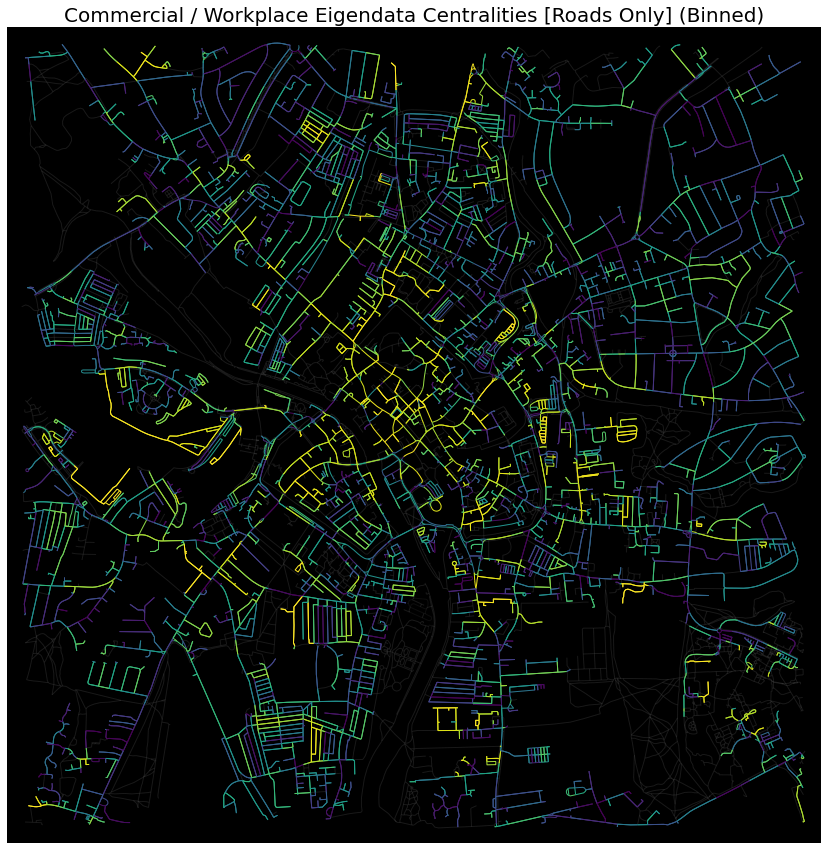

In [13]:
road_eigs = dict(road_graph.nodes(data='eigendata')).values()

# Create Colours
norm=plt.Normalize(vmin=min(road_eigs), vmax=max(road_eigs))
cmap=plt.cm.viridis

# Map colours to values (Binning)
edgeColours = ox.plot.get_edge_colors_by_attr(road_graph, attr='eigendata', num_bins=NUMBER_OF_BINS, equal_size=True, cmap=cmap)
nodeColours = ox.plot.get_node_colors_by_attr(road_graph, attr='eigendata', num_bins=NUMBER_OF_BINS, equal_size=True, cmap=cmap)

ax = None
fig, ax = ox.plot_graph(highway_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color=HIGHWAY_COLOUR, node_color=nodeColours, figsize=FIG_SIZE, edge_alpha=0.1)
fig, ax = ox.plot_graph(road_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color=edgeColours, node_color=nodeColours, figsize=FIG_SIZE)

plt.title('Commercial / Workplace Eigendata Centralities [Roads Only] (Binned)', fontsize=20)

plt.plot()

## Tag edges with travel times

In [14]:
dataMap = {}

for start, end, key, data in road_graph.edges(keys=True, data=True):
    if 'maxspeed' in data.keys():
        maxspeed = data['maxspeed'] # in Mph
        if type(maxspeed) == list:
            maxspeed = maxspeed[0]
        try:
            maxspeed = int(maxspeed)
        except:
            maxspeed = int(maxspeed[:-4])
    else:
        maxspeed = ASSUMED_MAX_SPEED

    length = data['length'] * 0.000621371 # convert to miles
    time = length / maxspeed * 60 # iconvert from hours to minutes
    dataMap[(start, end, key)] = time

nx.set_edge_attributes(road_graph, dataMap, name='travel_time')

## Tag nodes with building and home selection probabilities

In [15]:
dataMap = create_data_map(road_graph, home_set)
nx.set_node_attributes(road_graph, dataMap, name='home_selection_probability')

In [16]:
dataMap = create_data_map(road_graph, building_set)
nx.set_node_attributes(road_graph, dataMap, name='building_selection_probability')

## Create set of journeys

In [17]:
origin_weights = dict(road_graph.nodes(data='home_selection_probability'))
origins = random.choices(range(len(origin_weights)), weights=origin_weights, k=NUMBER_OF_JOURNEYS)

destination_weights = dict(road_graph.nodes(data='building_selection_probability'))
destinations = random.choices(range(len(destination_weights)), weights=destination_weights, k=NUMBER_OF_JOURNEYS)

# Evaluate Journeys on unaltered road graph

In [18]:
completed = []
travel_times = []
failed_nodes = []

for j in range(len(origins)):
    try:
        travel_times.append(nx.dijkstra_path_length(road_graph, origins[j], destinations[j], weight='travel_time'))
        completed.append(True)
    except nx.NetworkXNoPath:
        travel_times.append(None)
        completed.append(False)
        failed_nodes.append(origins[j])
        failed_nodes.append(destinations[j])

Text(0.5, 1.0, 'Nodes that were part of a failed journey')

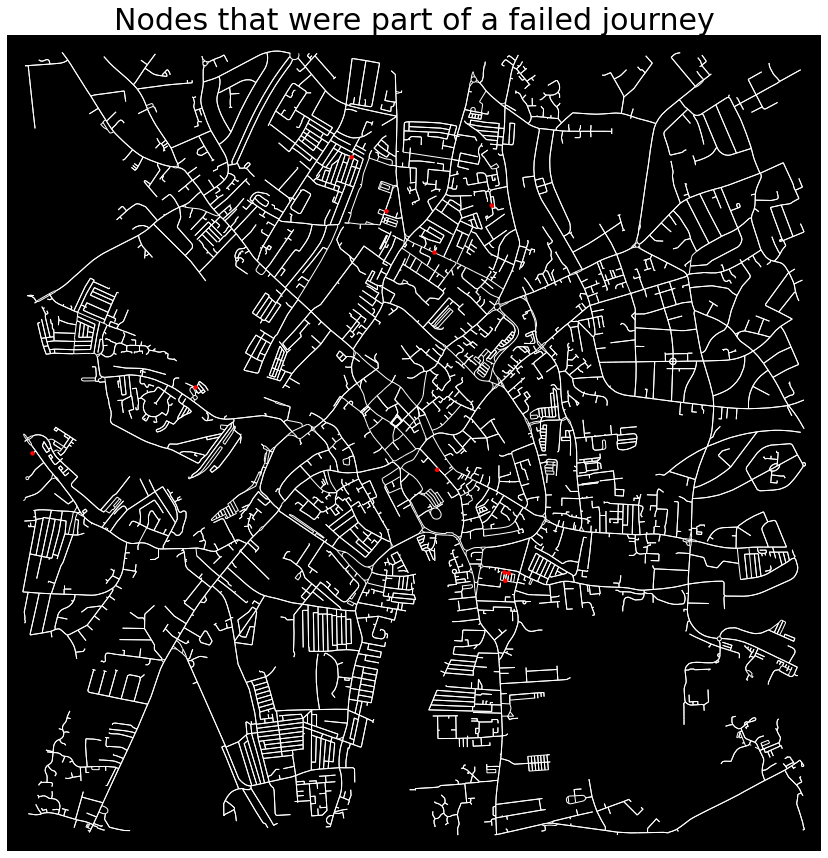

In [19]:
sizes = [20 if node in failed_nodes else 0 for node in list(road_graph.nodes)]

ax = None
fig, ax = ox.plot_graph(road_graph, ax=ax, show=False, node_size=sizes, bgcolor=BG_COLOUR, edge_color="white", node_color="red", figsize=FIG_SIZE)
plt.title("Nodes that were part of a failed journey", size=30)

99.5% of journeys completable


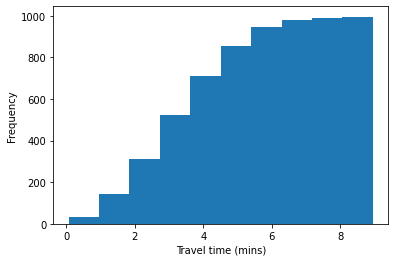

In [20]:
print(str(sum(completed)/NUMBER_OF_JOURNEYS*100) + "% of journeys completable")
plt.hist([elm for elm in travel_times if elm != None], cumulative=True)
plt.xlabel("Travel time (mins)")
plt.ylabel("Frequency")
plt.show()

# Evaluate Impact of Removing Each Road

In [21]:
def evaluate_journeys(graph, origins, destinations):
    completed = []
    travel_times = []

    for j in range(len(origins)):
        try:
            travel_times.append(nx.dijkstra_path_length(graph, origins[j], destinations[j], weight='travel_time'))
            completed.append(True)
        except nx.NetworkXNoPath:
            travel_times.append(None)
            completed.append(False)
    
    return completed, travel_times

In [208]:
# Prepare a sorted list of roads to remove
eligible_for_removal = road_graph.copy()

for edge in road_graph.edges(keys=True, data=True):
    if edge[3]["highway"] in HIGHWAY_TYPES_TO_ALWAYS_KEEP:
        eligible_for_removal.remove_edge(edge[0], edge[1], edge[2])
        
roads_to_remove = sorted(eligible_for_removal.edges(keys=True, data=True), key=lambda t: t[3].get('eigendata', 1), reverse=True)

# Calculate the number of roads to remove
num_to_remove = int(len(roads_to_remove)*PROPORTION_TO_PEDESTRIANISE)

In [23]:
# Evaluate effect of removing each road

summary = []

for i in range(num_to_remove):
    print(i/num_to_remove)
    reduced_road_graph = road_graph.copy()
    reduced_road_graph.remove_edge(roads_to_remove[i][0], roads_to_remove[i][1], roads_to_remove[i][2])

    new_completed, new_travel_times = evaluate_journeys(reduced_road_graph, origins, destinations)

    tt_dif = []
    for j in range(len(new_travel_times)):
        if new_completed[j]:
            tt_dif.append(new_travel_times[j]-travel_times[j])
        else:
            tt_dif.append(None)

    summary.append({'edge': roads_to_remove[i], 'completed': new_completed, 'travel times': new_travel_times, 'travel times dif': tt_dif})

0.0
0.006369426751592357
0.012738853503184714
0.01910828025477707
0.025477707006369428
0.03184713375796178
0.03821656050955414
0.044585987261146494
0.050955414012738856
0.05732484076433121
0.06369426751592357
0.07006369426751592
0.07643312101910828
0.08280254777070063
0.08917197452229299
0.09554140127388536
0.10191082802547771
0.10828025477707007
0.11464968152866242
0.12101910828025478
0.12738853503184713
0.1337579617834395
0.14012738853503184
0.1464968152866242
0.15286624203821655
0.1592356687898089
0.16560509554140126
0.17197452229299362
0.17834394904458598
0.18471337579617833
0.1910828025477707
0.19745222929936307
0.20382165605095542
0.21019108280254778
0.21656050955414013
0.2229299363057325
0.22929936305732485
0.2356687898089172
0.24203821656050956
0.2484076433121019
0.25477707006369427
0.2611464968152866
0.267515923566879
0.27388535031847133
0.2802547770700637
0.28662420382165604
0.2929936305732484
0.29936305732484075
0.3057324840764331
0.31210191082802546
0.3184713375796178
0.324

In [156]:
len(summary)

157

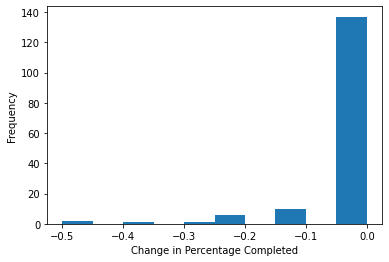

In [171]:
# Show effects on completability

data = [(sum(entry['completed'])-sum(completed))/NUMBER_OF_JOURNEYS*100 for entry in summary]

plt.hist(data)
plt.xlabel("Change in Percentage Completed")
plt.ylabel("Frequency")
plt.show()

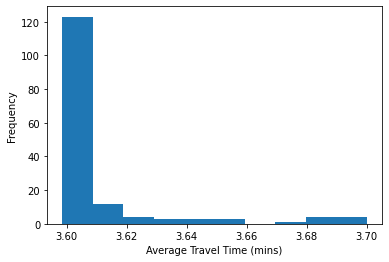

In [167]:
# Show effects on journey time
new_travel_times = [[elm for elm in entry['travel times'] if elm != None] for entry in summary]
averages = [sum(entry)/len(entry) for entry in new_travel_times]

plt.hist(averages)
plt.xlabel("Average Travel Time (mins)")
plt.ylabel("Frequency")
plt.show()

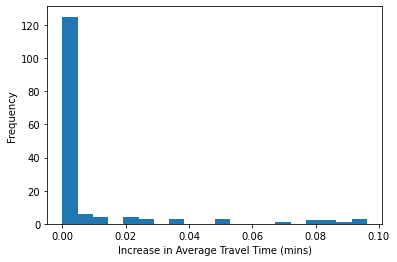

In [169]:
# Show effects on journey time
new_travel_times_dif = [[elm for elm in entry['travel times dif'] if elm != None] for entry in summary]
averages = [sum(entry)/len(entry) for entry in new_travel_times_dif]

plt.hist(averages, bins=20)
plt.xlabel("Increase in Average Travel Time (mins)")
plt.ylabel("Frequency")
plt.show()

# Evaluate Impact of Removing Only the highest eigenvalue road

In [181]:
reduced_road_graph = road_graph.copy()
reduced_road_graph.remove_edge(roads_to_remove[0][0], roads_to_remove[0][1], roads_to_remove[0][2])

new_completed, new_travel_times = evaluate_journeys(reduced_road_graph, origins, destinations)

tt_dif = []
for j in range(len(new_travel_times)):
    if new_completed[j]:
        tt_dif.append(new_travel_times[j]-travel_times[j])
    else:
        tt_dif.append(None)

In [182]:
# Show effects on completability

data = (sum(completed)-sum(new_completed))/NUMBER_OF_JOURNEYS*100

print(str(data) + "% fewer journeys completable")

0.2% fewer journeys completable


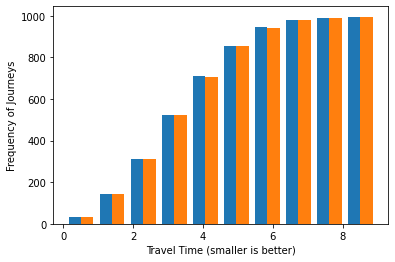

In [183]:
# Show effects on journey time

plt.hist([[elm for elm in travel_times if elm != None],[elm for elm in new_travel_times if elm != None]], cumulative=True)
plt.xlabel("Travel Time (smaller is better)")
plt.ylabel("Frequency of Journeys")
plt.show()

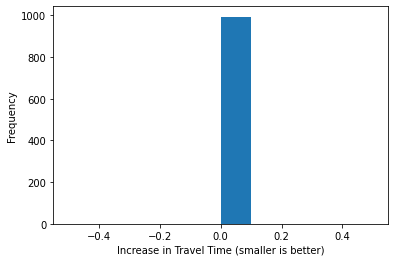

In [184]:
# Show effects on journey time
new_travel_times_dif = [elm for elm in tt_dif if elm != None]

plt.hist(new_travel_times_dif)
plt.xlabel("Increase in Travel Time (smaller is better)")
plt.ylabel("Frequency")
plt.show()

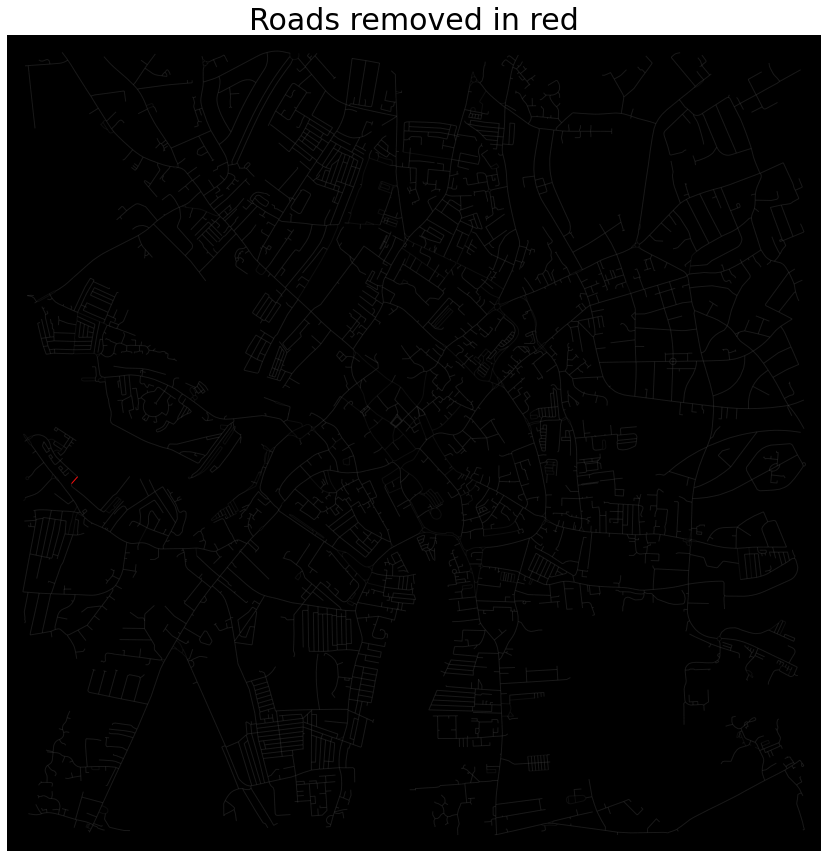

In [185]:
removed_road_graph = road_graph.copy()
for edge in road_graph.edges():
    if edge in reduced_road_graph.edges():
        removed_road_graph.remove_edge(edge[0], edge[1])

ax = None
fig, ax = ox.plot_graph(removed_road_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color='red', figsize=FIG_SIZE)
fig, ax = ox.plot_graph(reduced_road_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color=HIGHWAY_COLOUR, figsize=FIG_SIZE, edge_alpha=0.1)
plt.title("Roads removed in red", size=30)
plt.show()

# Evaluate Impact of Removing Multiple Roads

## Only those with no impact on completeability or travel time

In [186]:
# Remove all which had no difference in completeability and travel time

reduced_road_graph = road_graph.copy()

for i in range(num_to_remove):

    if summary[i]["completed"] == completed and summary[i]["travel times"] == travel_times:
        reduced_road_graph.remove_edge(roads_to_remove[i][0], roads_to_remove[i][1], roads_to_remove[i][2])


new_completed, new_travel_times = evaluate_journeys(reduced_road_graph, origins, destinations)

new_tt_dif = []
for j in range(len(new_travel_times)):
    if new_completed[j]:
        new_tt_dif.append(new_travel_times[j]-travel_times[j])
    else:
        new_tt_dif.append(None)



In [187]:
# Show effects on completability

str((sum(completed) - sum(new_completed))/ NUMBER_OF_JOURNEYS * 100) + "% fewer journeys could be completed"

'0.0% fewer journeys could be completed'

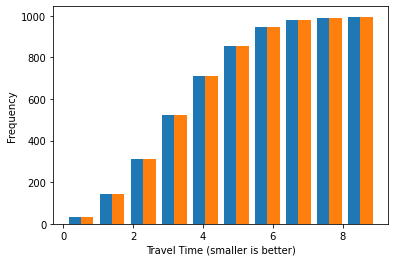

In [188]:
# Show effects on journey time
data = [elm for elm in travel_times if elm != None], [elm for elm in new_travel_times if elm != None]

print()

plt.hist(data, cumulative=True)
plt.xlabel("Travel Time (smaller is better)")
plt.ylabel("Frequency")
plt.show()

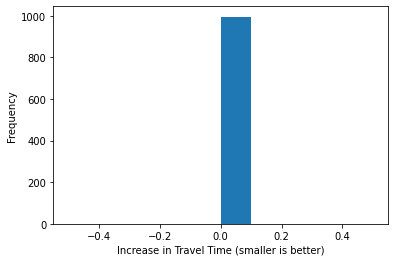

In [189]:
# Show effects on journey time
data = [val for val in new_tt_dif if val != None]

plt.hist(data)
plt.xlabel("Increase in Travel Time (smaller is better)")
plt.ylabel("Frequency")
plt.show()

58


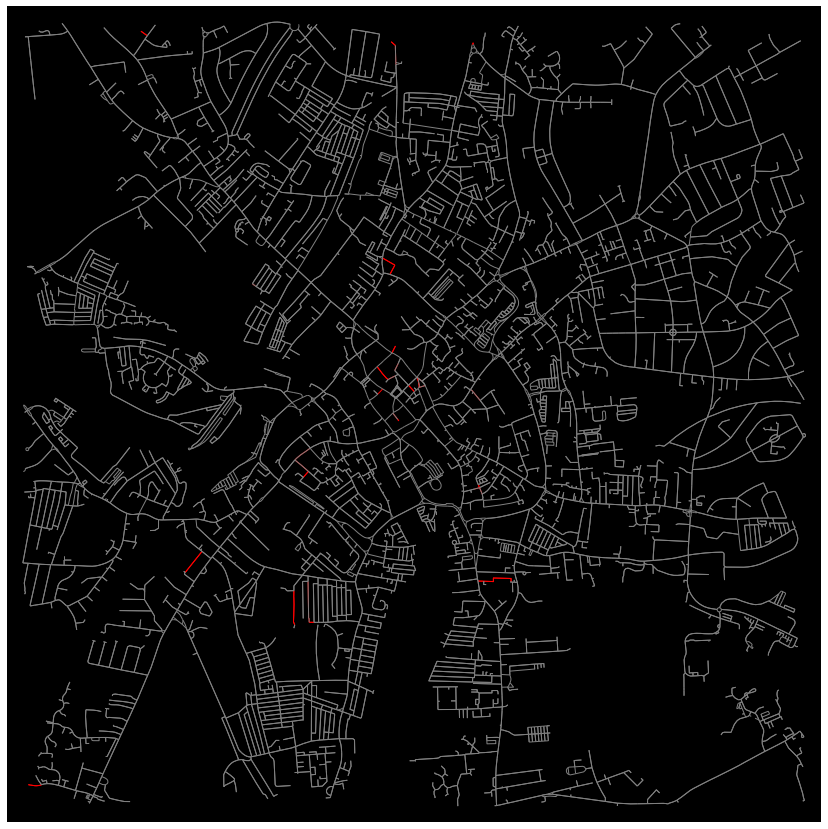

In [190]:
removed_road_graph = road_graph.copy()
for edge in road_graph.edges():
    if edge in reduced_road_graph.edges():
        removed_road_graph.remove_edge(edge[0], edge[1])

print(len(removed_road_graph.edges()))

ax = None
fig, ax = ox.plot_graph(removed_road_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color='red', figsize=FIG_SIZE)
fig, ax = ox.plot_graph(reduced_road_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color=HIGHWAY_COLOUR, figsize=FIG_SIZE)
# plt.title("Roads removed in red", size=30)
plt.show()

## Only those with impact on only one of either completeability or travel time

In [210]:
# Remove all which had no difference in completeability and travel time

reduced_road_graph = road_graph.copy()

for i in range(num_to_remove):

    if summary[i]["completed"] == completed or summary[i]["travel times"] == travel_times:
        reduced_road_graph.remove_edge(roads_to_remove[i][0], roads_to_remove[i][1], roads_to_remove[i][2])


new_completed, new_travel_times = evaluate_journeys(reduced_road_graph, origins, destinations)

new_tt_dif = []
for j in range(len(new_travel_times)):
    if new_completed[j]:
        new_tt_dif.append(new_travel_times[j]-travel_times[j])
    else:
        new_tt_dif.append(None)

In [219]:
# Show effects on completability

str((sum(completed) - sum(new_completed))/ NUMBER_OF_JOURNEYS * 100) + "% fewer journeys could be completed", str(sum(new_completed)/ NUMBER_OF_JOURNEYS * 100) + "%"

('3.3000000000000003% fewer journeys could be completed', '96.2%')

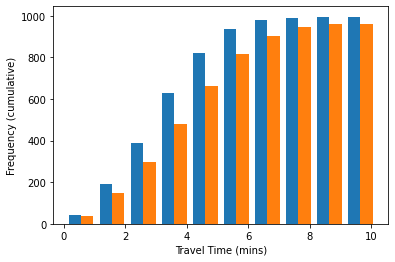

In [222]:
# Show effects on journey time
data = [elm for elm in travel_times if elm != None], [elm for elm in new_travel_times if elm != None]

plt.hist(data, cumulative=True)
plt.xlabel("Travel Time (mins)")
plt.ylabel("Frequency (cumulative)")
plt.show()

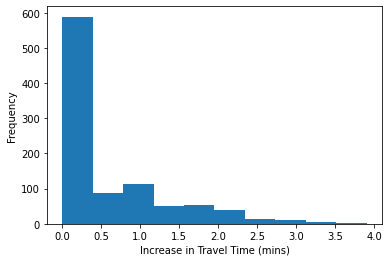

In [223]:
# Show effects on journey time
data = [val for val in new_tt_dif if val != None]

plt.hist(data)
plt.xlabel("Increase in Travel Time (mins)")
plt.ylabel("Frequency")
plt.show()

137


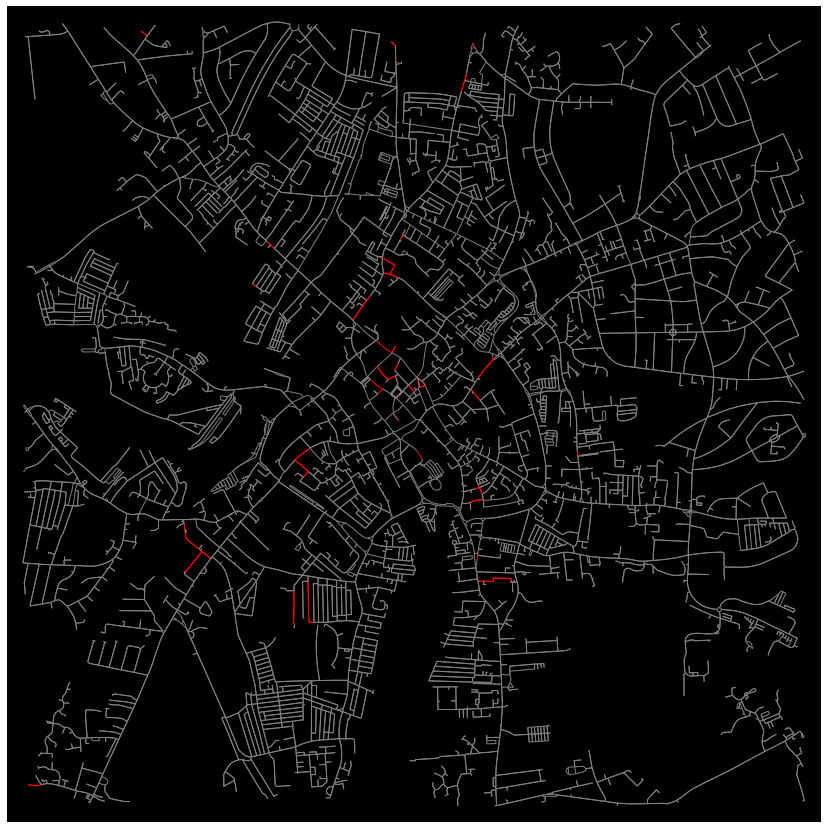

In [215]:
removed_road_graph = road_graph.copy()
for edge in road_graph.edges():
    if edge in reduced_road_graph.edges():
        removed_road_graph.remove_edge(edge[0], edge[1])

print(len(removed_road_graph.edges()))

ax = None
fig, ax = ox.plot_graph(removed_road_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color='red', figsize=FIG_SIZE)
fig, ax = ox.plot_graph(reduced_road_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color=HIGHWAY_COLOUR, figsize=FIG_SIZE)
# plt.title("Roads removed in red", size=30)
plt.show()

## Any with a small impact 

In [196]:
# Remove all which had no difference in completeability and travel time

reduced_road_graph = road_graph.copy()

for i in range(num_to_remove):
    tt_dif = [elm for elm in summary[i]["travel times dif"] if elm != None]
    if ((sum(completed)-sum(summary[i]["completed"]))/NUMBER_OF_JOURNEYS < 0.002) and (sum(tt_dif)/len(tt_dif) < 0.03):
        reduced_road_graph.remove_edge(roads_to_remove[i][0], roads_to_remove[i][1], roads_to_remove[i][2])


new_completed, new_travel_times = evaluate_journeys(reduced_road_graph, origins, destinations)

new_tt_dif = []
for j in range(len(new_travel_times)):
    if new_completed[j]:
        new_tt_dif.append(new_travel_times[j]-travel_times[j])
    else:
        new_tt_dif.append(None)



In [197]:
# Show effects on completability

str((sum(completed) - sum(new_completed))/ NUMBER_OF_JOURNEYS * 100) + "% fewer journeys could be completed"

'3.1% fewer journeys could be completed'

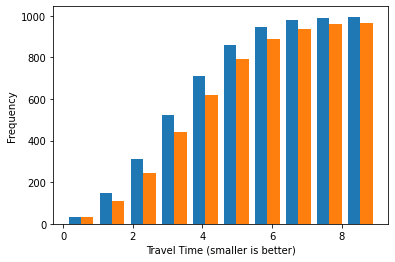

In [198]:
# Show effects on journey time
data = [elm for elm in travel_times if elm != None], [elm for elm in new_travel_times if elm != None]

plt.hist(data, cumulative=True)
plt.xlabel("Travel Time (smaller is better)")
plt.ylabel("Frequency")
plt.show()

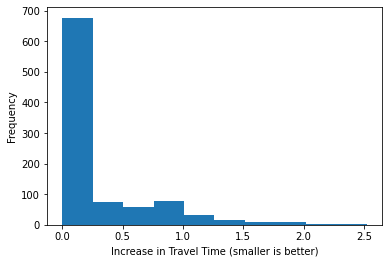

In [199]:
# Show effects on journey time
data = [val for val in new_tt_dif if val != None]

plt.hist(data)
plt.xlabel("Increase in Travel Time (smaller is better)")
plt.ylabel("Frequency")
plt.show()

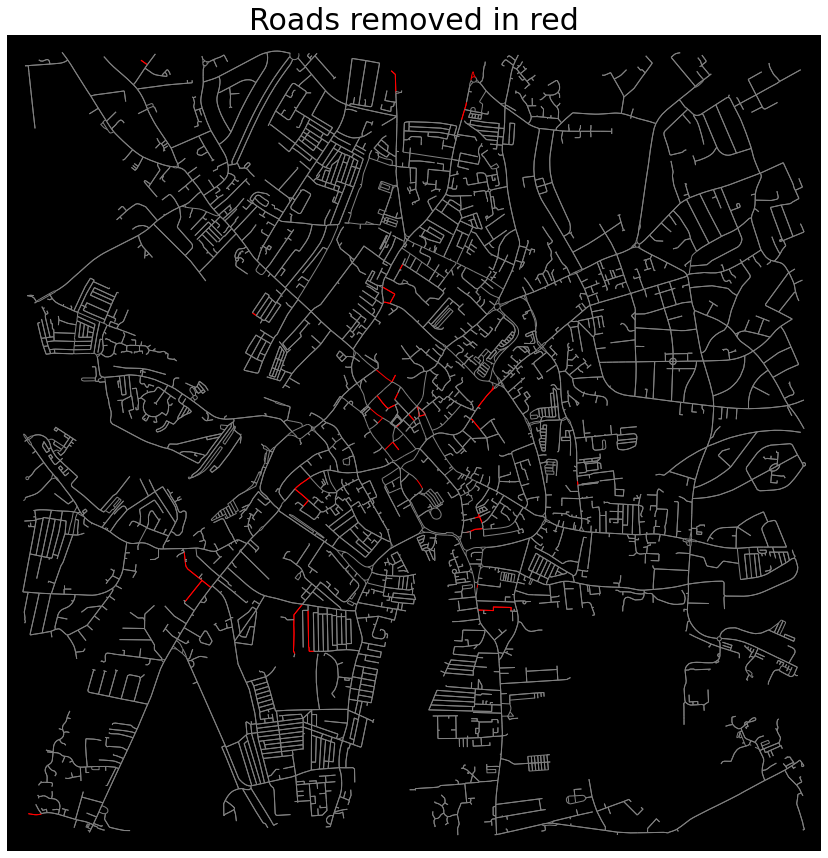

In [200]:
removed_road_graph = road_graph.copy()
for edge in road_graph.edges():
    if edge in reduced_road_graph.edges():
        removed_road_graph.remove_edge(edge[0], edge[1])

ax = None
fig, ax = ox.plot_graph(removed_road_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color='red', figsize=FIG_SIZE)
fig, ax = ox.plot_graph(reduced_road_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color=HIGHWAY_COLOUR, figsize=FIG_SIZE)
plt.title("Roads removed in red", size=30)
plt.show()

## Top 2% Regardless

In [201]:
# Remove all which had no difference in completeability and travel time

reduced_road_graph = road_graph.copy()

for i in range(num_to_remove):
    reduced_road_graph.remove_edge(roads_to_remove[i][0], roads_to_remove[i][1], roads_to_remove[i][2])

new_completed, new_travel_times = evaluate_journeys(reduced_road_graph, origins, destinations)

new_tt_dif = []
for j in range(len(new_travel_times)):
    if new_completed[j]:
        new_tt_dif.append(new_travel_times[j]-travel_times[j])
    else:
        new_tt_dif.append(None)

In [202]:
# Show effects on completability

str((sum(completed) - sum(new_completed))/ NUMBER_OF_JOURNEYS * 100) + "% fewer journeys could be completed"

'5.7% fewer journeys could be completed'

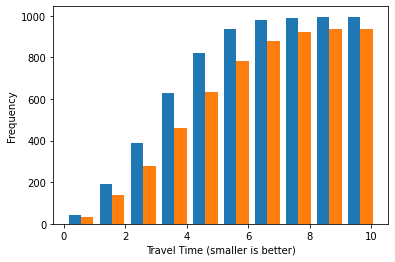

In [203]:
# Show effects on journey time
data = [elm for elm in travel_times if elm != None], [elm for elm in new_travel_times if elm != None]

plt.hist(data, cumulative=True)
plt.xlabel("Travel Time (smaller is better)")
plt.ylabel("Frequency")
plt.show()

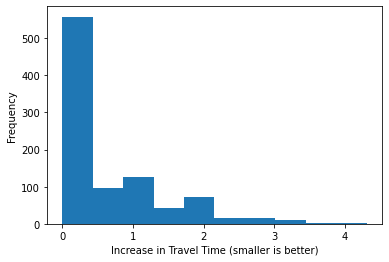

In [204]:
# Show effects on journey time
data = [val for val in new_tt_dif if val != None]

plt.hist(data)
plt.xlabel("Increase in Travel Time (smaller is better)")
plt.ylabel("Frequency")
plt.show()

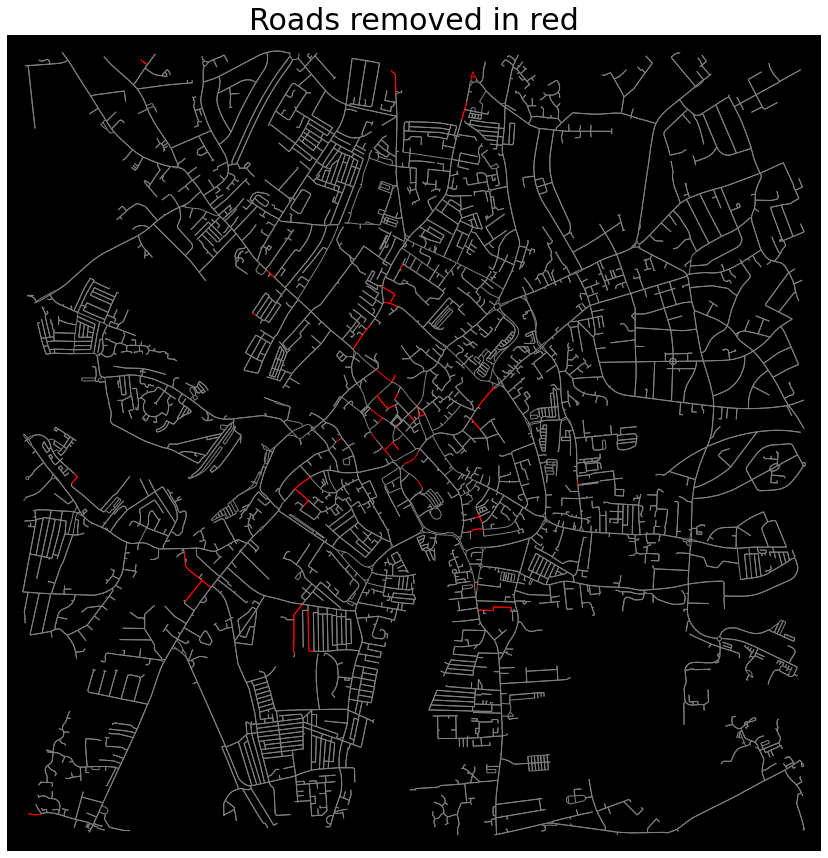

In [205]:
removed_road_graph = road_graph.copy()
for edge in road_graph.edges():
    if edge in reduced_road_graph.edges():
        removed_road_graph.remove_edge(edge[0], edge[1])

ax = None
fig, ax = ox.plot_graph(removed_road_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color='red', figsize=FIG_SIZE)
fig, ax = ox.plot_graph(reduced_road_graph, ax=ax, show=False, node_size=NODE_SIZE, bgcolor=BG_COLOUR, edge_color=HIGHWAY_COLOUR, figsize=FIG_SIZE)
plt.title("Roads removed in red", size=30)
plt.show()